In [15]:
import numpy as np
import heapq
from itertools import product
from tabulate import tabulate
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

class NDimensionalPlatesManager:
    def __init__(self, plate_dimensions):
        """
        Initializes the PlatesManager with the dimensions for the plates.
        """
        self.plate_dimensions = plate_dimensions
        self.dimensions = len(plate_dimensions)
        self.plates = []
        self.available_slots = []  # Priority queue to track available slots
    
    def calculate_cost(self):
        """
        Calculate the cost of the plate arrangement based on the number of plates used
        and the unused space on each plate.
        """
        num_plates = len(self.plates)
        plate_volume = np.prod(self.plate_dimensions)
        unused_space = sum(np.count_nonzero(plate == 0) for plate in self.plates)
        cost = num_plates * plate_volume + unused_space
        return cost
    
    def create_plate(self):
        """
        Create an initial plate with the specified size.
        """
        initial_plate = np.zeros(self.plate_dimensions, dtype=int)
        self.plates.append(initial_plate)
        heapq.heappush(self.available_slots, (np.prod(self.plate_dimensions), len(self.plates) - 1))
        
    def split_large_shape(self, rect_dims):
        """
        Splits a large rectangle into smaller sub-rectangles to fit into plates.
        """
        rect_depth, rect_height, rect_width = rect_dims
        sub_rectangles = []

        while rect_depth > self.plate_dimensions[0] or \
            rect_height > self.plate_dimensions[1] or \
            rect_width > self.plate_dimensions[2]:
            # Split along the largest dimension exceeding plate size
            if rect_depth > self.plate_dimensions[0]:
                sub_rectangles.append((self.plate_dimensions[0], rect_height, rect_width))
                rect_depth -= self.plate_dimensions[0]
            elif rect_height > self.plate_dimensions[1]:
                sub_rectangles.append((rect_depth, self.plate_dimensions[1], rect_width))
                rect_height -= self.plate_dimensions[1]
            elif rect_width > self.plate_dimensions[2]:
                sub_rectangles.append((rect_depth, rect_height, self.plate_dimensions[2]))
                rect_width -= self.plate_dimensions[2]

        # Add the remaining part
        if rect_depth <= self.plate_dimensions[0] and \
        rect_height <= self.plate_dimensions[1] and \
        rect_width <= self.plate_dimensions[2]:
            sub_rectangles.append((rect_depth, rect_height, rect_width))

        return sub_rectangles
    
    def find_and_place_shape(self, shape_dimensions, fill_value, allow_rotation=False):
        """
        Try to place a shape on the plates or split it if it's too large.
        """
        best_cost = float('inf')
        best_plates = self.plates.copy()
        
        # Generate permutations of shape dimensions for rotations
        shapes_to_try = [shape_dimensions]
        if allow_rotation:
            shapes_to_try = list(set(product(*[perm for perm in map(sorted, product(shape_dimensions))])))
        
        for shape in shapes_to_try:
            # Split the shape if necessary
            if any(shape[d] > self.plate_dimensions[d] for d in range(self.dimensions)):
                sub_shapes = self.split_large_shape(shape)
            else:
                sub_shapes = [shape]
            
            plates_copy = [plate.copy() for plate in self.plates]
            available_slots_copy = self.available_slots.copy()
            success = True
            
            for sub_shape in sub_shapes:
                if not self.place_shape_on_plates(plates_copy, available_slots_copy, sub_shape, fill_value):
                    success = False
                    break
            
            if success:
                cost = self.calculate_cost()
                if cost < best_cost:
                    best_cost = cost
                    best_plates = plates_copy
        
        self.plates = best_plates
    
    def place_shape_on_plates(self, plates, available_slots, shape, fill_value):
        """
        Attempt to place a shape on existing plates or create new plates if needed.
        """
        for plate in plates:
            for indices in product(*(range(plate.shape[d] - shape[d] + 1) for d in range(self.dimensions))):
                slices = tuple(slice(indices[d], indices[d] + shape[d]) for d in range(self.dimensions))
                if np.all(plate[slices] == 0):
                    plate[slices] = fill_value
                    return True

        # If no placement is possible, create a new plate
        new_plate = np.zeros(self.plate_dimensions, dtype=int)
        plates.append(new_plate)
        slices = tuple(slice(0, shape[d]) for d in range(self.dimensions))
        new_plate[slices] = fill_value
        return True

    def plot_plates(self):
        """
        Improved 3D visualization for plates. Each fill value is assigned a unique color, 
        and transparency is added for better visibility of overlapping shapes.
        """
        if self.dimensions != 3:
            print("Visualization only supported for 3D plates.")
            return

        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')

        # Generate a colormap
        unique_values = np.unique(np.concatenate([plate.flatten() for plate in self.plates]))
        cmap = plt.cm.get_cmap("tab20", len(unique_values))
        color_map = {value: cmap(i) for i, value in enumerate(unique_values)}

        for plate_index, plate in enumerate(self.plates):
            for value in unique_values:
                if value == 0:
                    continue  # Skip empty spaces

                # Get the coordinates of all points with the current value
                positions = np.argwhere(plate == value)
                x, y, z = positions[:, 0], positions[:, 1], positions[:, 2]

                # Add points to the plot with transparency
                ax.scatter(
                    x + plate_index * self.plate_dimensions[0],  # Offset by plate index
                    y,
                    z,
                    color=color_map[value],
                    label=f'Value {value}' if plate_index == 0 else None,  # Avoid duplicate labels
                    alpha=0.7,  # Transparency
                    s=50  # Point size
                )

            # Draw plate boundaries
            plate_offset = plate_index * self.plate_dimensions[0]
            plate_corners = np.array([
                [plate_offset, 0, 0],
                [plate_offset, self.plate_dimensions[1], 0],
                [plate_offset, self.plate_dimensions[1], self.plate_dimensions[2]],
                [plate_offset, 0, self.plate_dimensions[2]],
                [plate_offset, 0, 0],  # Back to the start
            ])
            for dim in range(1, 4):
                ax.plot(
                    plate_corners[:, 0], plate_corners[:, 1], plate_corners[:, 2], "k--", lw=1
                )

        # Set axis labels
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")

        # Set equal aspect ratio
        ax.set_box_aspect([np.prod(self.plate_dimensions)] * 3)

        # Add legend
        ax.legend(loc="upper left", bbox_to_anchor=(1.1, 1), title="Fill Values")

        # Add grid and show the plot
        ax.grid(True)
        plt.tight_layout()
        plt.show()
        
    def plot_voxelized_plates(self):
        """
        Visualizes the plates in 3D using a voxel-based representation.
        Each unique fill value is assigned a distinct color.
        """
        if self.dimensions != 3:
            print("Voxelized visualization only supported for 3D plates.")
            return

        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')

        # Generate a colormap
        unique_values = np.unique(np.concatenate([plate.flatten() for plate in self.plates]))
        cmap = plt.cm.get_cmap("tab20", len(unique_values))
        color_map = {value: cmap(i) for i, value in enumerate(unique_values)}

        # Create a full 3D grid to accumulate voxels
        total_shape = (
            len(self.plates) * self.plate_dimensions[0],
            self.plate_dimensions[1],
            self.plate_dimensions[2],
        )
        full_voxels = np.zeros(total_shape, dtype=bool)
        full_colors = np.empty(total_shape, dtype=object)

        # Populate the voxel grid
        for plate_index, plate in enumerate(self.plates):
            offset = plate_index * self.plate_dimensions[0]
            for value in unique_values:
                if value == 0:
                    continue  # Skip empty spaces
                positions = np.argwhere(plate == value)
                for x, y, z in positions:
                    full_voxels[offset + x, y, z] = True
                    full_colors[offset + x, y, z] = color_map[value]

        # Plot the voxels
        ax.voxels(full_voxels, facecolors=full_colors, edgecolor="k", alpha=0.8)

        # Add labels and grid
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
        ax.grid(True)

        # Set aspect ratio
        ax.set_box_aspect(total_shape)

        plt.show()


# Example usage:
if __name__ == "__main__":
    plate_manager = NDimensionalPlatesManager((5, 5, 5))  # Initialize a 5x5x5 3D plate
    plate_manager.create_plate()
    
    plate_manager.find_and_place_shape((3, 3, 3), fill_value=1, allow_rotation=True)  # Large shape, requires splitting


    # for i in range(10):
    #         plate_manager.find_and_place_shape((2, 2, 2), fill_value=1+i, allow_rotation=True)  # Large shape, requires splitting
    #         plate_manager.find_and_place_shape((1,3,1),11)

    
    plate_manager.plot_plates()
    plate_manager.plot_voxelized_plates()
    print("Cost:", plate_manager.calculate_cost())


SyntaxError: invalid syntax (2016618185.py, line 244)

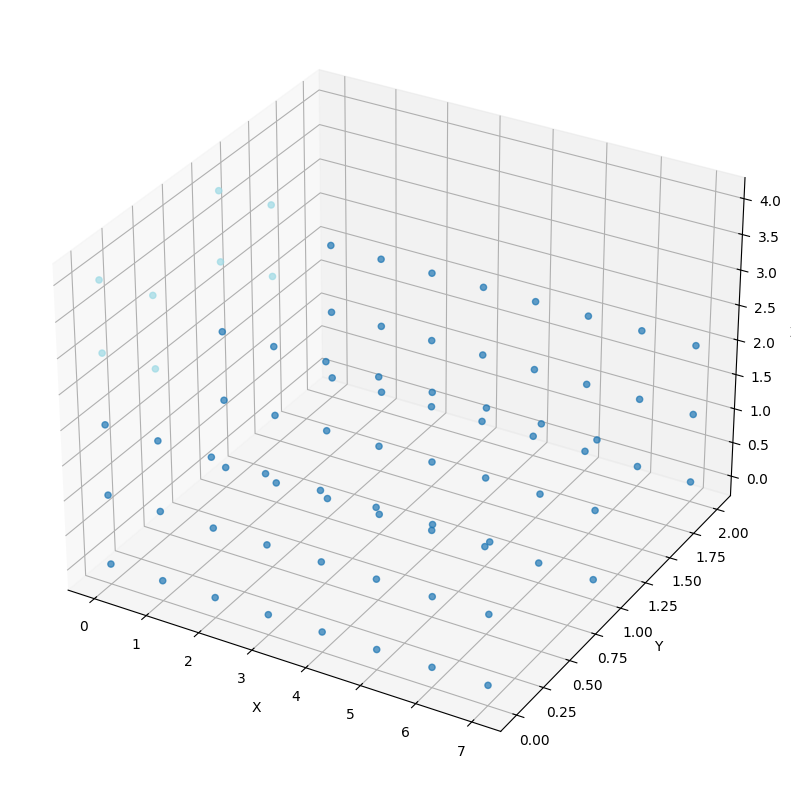

C:\Users\capti\AppData\Local\Temp\ipykernel_145472\160424505.py:181: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



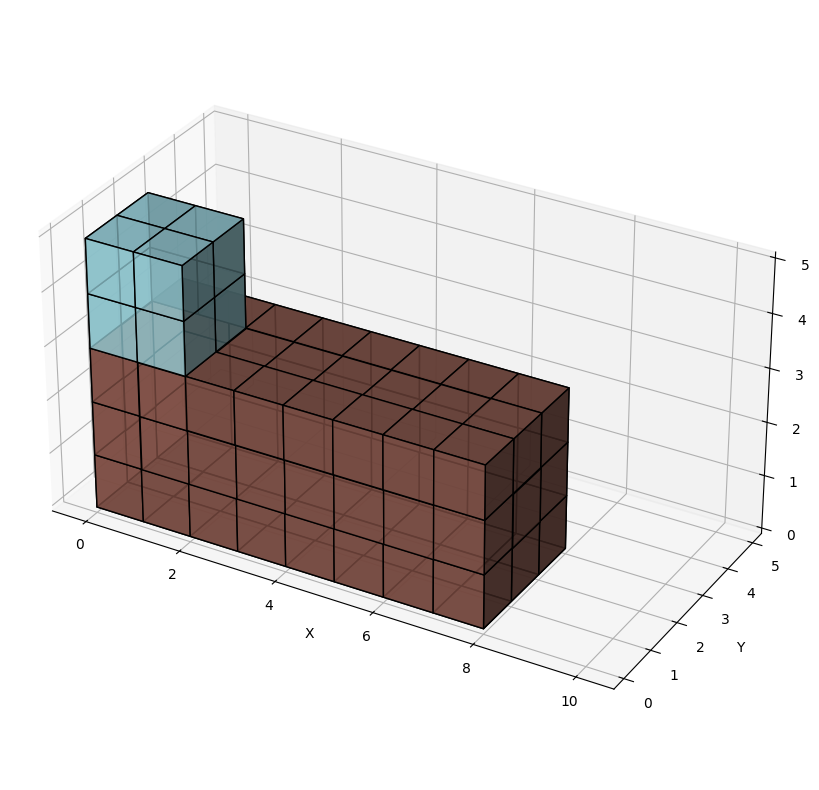

Cost: 420


In [58]:
import numpy as np
import heapq
from itertools import product, permutations
from tabulate import tabulate
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go


class NDimensionalPlatesManager:
    def __init__(self, plate_dimensions):
        """
        Initializes the PlatesManager with the dimensions for the plates.
        
        Args:
            plate_dimensions (tuple): Dimensions of a single plate (e.g., (depth, height, width)).
        """
        self.plate_dimensions = plate_dimensions
        self.dimensions = len(plate_dimensions)
        self.plates = []  # List of plates
        self.available_slots = []  # Priority queue for available slots
    
    def calculate_cost(self):
        """
        Calculates the cost of the plate arrangement.

        Cost is based on:
        - Number of plates used (each plate has a base volume cost).
        - Unused space in the plates (penalized as additional cost).

        Returns:
            float: The calculated cost.
        """
        num_plates = len(self.plates)
        plate_volume = np.prod(self.plate_dimensions)
        unused_space = sum(np.count_nonzero(plate == 0) for plate in self.plates)
        return num_plates * plate_volume + unused_space
    
    def create_plate(self):
        """
        Creates a new plate and adds it to the list of plates.
        """
        new_plate = np.zeros(self.plate_dimensions, dtype=int)
        self.plates.append(new_plate)
        heapq.heappush(self.available_slots, (np.prod(self.plate_dimensions), len(self.plates) - 1))
    
    def split_large_shape(self, rect_dims):
        """
        Splits a large shape into smaller sub-shapes that fit within a single plate.

        Args:
            rect_dims (tuple): Dimensions of the large shape (e.g., (depth, height, width)).

        Returns:
            list of tuples: List of smaller sub-shape dimensions.
        """
        remaining_dims = list(rect_dims)
        sub_shapes = []

        for i in range(self.dimensions):
            while remaining_dims[i] > self.plate_dimensions[i]:
                split_dims = remaining_dims[:]
                split_dims[i] = self.plate_dimensions[i]
                sub_shapes.append(tuple(split_dims))
                remaining_dims[i] -= self.plate_dimensions[i]

        sub_shapes.append(tuple(remaining_dims))
        return sub_shapes
    
    def place_shape_on_plates(self, plates, available_slots, shape, fill_value):
        """
        Attempts to place a shape onto existing plates or creates a new plate if necessary.

        Args:
            plates (list): Current list of plates.
            available_slots (list): Priority queue for available slots.
            shape (tuple): Dimensions of the shape to place.
            fill_value (int): Value used to fill the shape.

        Returns:
            bool: True if the shape was placed successfully, False otherwise.
        """
        for plate in plates:
            for indices in product(*(range(plate.shape[d] - shape[d] + 1) for d in range(self.dimensions))):
                slices = tuple(slice(indices[d], indices[d] + shape[d]) for d in range(self.dimensions))
                if np.all(plate[slices] == 0):
                    plate[slices] = fill_value
                    return True

        # If no space is available, create a new plate
        new_plate = np.zeros(self.plate_dimensions, dtype=int)
        plates.append(new_plate)
        slices = tuple(slice(0, shape[d]) for d in range(self.dimensions))
        new_plate[slices] = fill_value
        return True
    
    def find_and_place_shape(self, shape_dimensions, fill_value, allow_rotation=False):
        """
        Finds the optimal placement for a shape on the plates.

        Args:
            shape_dimensions (tuple): Dimensions of the shape to place.
            fill_value (int): Value to fill the shape with.
            allow_rotation (bool): Whether to allow rotation of the shape.
        """
        best_cost = float('inf')
        best_plates = None

        # Generate all permutations of shape dimensions for rotation
        shape_variants = [shape_dimensions]
        if allow_rotation:
            shape_variants = set(permutations(shape_dimensions))

        for shape in shape_variants:
            sub_shapes = (
                self.split_large_shape(shape) if any(shape[d] > self.plate_dimensions[d] for d in range(self.dimensions))
                else [shape]
            )

            plates_copy = [plate.copy() for plate in self.plates]
            available_slots_copy = self.available_slots.copy()

            success = all(
                self.place_shape_on_plates(plates_copy, available_slots_copy, sub_shape, fill_value)
                for sub_shape in sub_shapes
            )

            if success:
                current_cost = self.calculate_cost()
                if current_cost < best_cost:
                    best_cost = current_cost
                    best_plates = plates_copy

        if best_plates is not None:
            self.plates = best_plates
    
    def plot_plates(self):
        """
        Visualizes the plates in 3D using Matplotlib.
        """
        if self.dimensions != 3:
            print("3D visualization is only supported for 3D plates.")
            return

        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')

        for plate_index, plate in enumerate(self.plates):
            positions = np.argwhere(plate > 0)
            values = plate[plate > 0]

            ax.scatter(
                positions[:, 0] + plate_index * self.plate_dimensions[0],
                positions[:, 1],
                positions[:, 2],
                c=values,
                cmap="tab20",
                alpha=0.7,
            )

        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
        plt.show()
    
   
    def plot_voxelized_plates(self):
            """
            Visualizes the plates in 3D using a voxel-based representation.
            Each unique fill value is assigned a distinct color.
            """
            if self.dimensions != 3:
                print("Voxelized visualization only supported for 3D plates.")
                return

            fig = plt.figure(figsize=(10, 10))
            ax = fig.add_subplot(111, projection='3d')

            # Generate a colormap
            unique_values = np.unique(np.concatenate([plate.flatten() for plate in self.plates]))
            cmap = plt.cm.get_cmap("tab20", len(unique_values))
            color_map = {value: cmap(i) for i, value in enumerate(unique_values)}

            # Create a full 3D grid to accumulate voxels
            total_shape = (
                len(self.plates) * self.plate_dimensions[0],
                self.plate_dimensions[1],
                self.plate_dimensions[2],
            )
            full_voxels = np.zeros(total_shape, dtype=bool)
            full_colors = np.empty(total_shape, dtype=object)

            # Populate the voxel grid
            for plate_index, plate in enumerate(self.plates):
                offset = plate_index * self.plate_dimensions[0]
                for value in unique_values:
                    if value == 0:
                        continue  # Skip empty spaces
                    positions = np.argwhere(plate == value)
                    for x, y, z in positions:
                        full_voxels[offset + x, y, z] = True
                        full_colors[offset + x, y, z] = color_map[value]

            # Plot the voxels
            ax.voxels(full_voxels, facecolors=full_colors, edgecolor="k", alpha=0.8)

            # Add labels and grid
            ax.set_xlabel("X")
            ax.set_ylabel("Y")
            ax.set_zlabel("Z")
            ax.grid(True)

            # Set aspect ratio
            ax.set_box_aspect(total_shape)

            plt.show()
            
    def plot_voxelized_platesI(self):
        """
        Visualizes the plates in 3D using Plotly's voxel-based representation.
        Each unique fill value is assigned a distinct color.
        """
        if self.dimensions != 3:
            print("Voxelized visualization only supported for 3D plates.")
            return

        # Create a combined 3D array that holds all plates stacked together
        combined = np.zeros((len(self.plates) * self.plate_dimensions[0], *self.plate_dimensions[1:]), dtype=int)
        for i, plate in enumerate(self.plates):
            combined[i * self.plate_dimensions[0]:(i + 1) * self.plate_dimensions[0]] = plate

        # Debug: Print unique values in the combined array to ensure there are non-zero voxels
        print("Unique values in the combined array:", np.unique(combined))

        # Find the coordinates of the non-zero voxels (the filled parts)
        x, y, z = np.where(combined > 0)

        if len(x) == 0:  # If there are no non-zero voxels
            print("No filled voxels found to display!")
            return

        # Define the values for these non-zero voxels (same as their original values)
        values = combined[x, y, z]

        # Create a custom color map based on unique voxel values
        unique_values = np.unique(values)
        colors = [f"rgb({np.random.randint(100, 255)}, {np.random.randint(100, 255)}, {np.random.randint(100, 255)})" for _ in unique_values]
        color_map = dict(zip(unique_values, colors))

        # Map voxel values to their corresponding colors
        voxel_colors = [color_map[val] for val in values]

        # Create the Plotly figure using Scatter3d (this allows better flexibility for colors)
        fig = go.Figure(data=go.Scatter3d(
            x=x,  # x coordinates for the voxels
            y=y,  # y coordinates for the voxels
            z=z,  # z coordinates for the voxels
            mode='markers',
            marker=dict(
                size=5,
                color=voxel_colors,  # Custom colors for each voxel
                opacity=0.8
            )
        ))

        # Calculate axis limits to match the size of the plates
        x_range = [0, combined.shape[0] - 1]
        y_range = [0, combined.shape[1] - 1]
        z_range = [0, combined.shape[2] - 1]

        # Update the layout for better interactivity and fixed aspect ratio
        fig.update_layout(
            title="Voxelized Plates Visualization with Custom Colors",
            scene=dict(
                xaxis=dict(
                    title="X",
                    range=x_range  # Set the range for X axis
                ),
                yaxis=dict(
                    title="Y",
                    range=y_range  # Set the range for Y axis
                ),
                zaxis=dict(
                    title="Z",
                    range=z_range  # Set the range for Z axis
                ),
                aspectmode="data"  # Make sure the aspect ratio is fixed
            ),
            showlegend=False  # Disable the legend as it's not necessary for this plot
        )

        # Show the figure with Plotly's interactive features
        fig.show()
        
    def plot_voxelized_platesV(self):
        """
        Visualizes the plates in 3D using Plotly's voxel-based representation.
        Each unique fill value is assigned a distinct color.
        """
        if self.dimensions != 3:
            print("Voxelized visualization only supported for 3D plates.")
            return

        # Create a combined 3D array that holds all plates stacked together
        combined = np.zeros((len(self.plates) * self.plate_dimensions[0], *self.plate_dimensions[1:]), dtype=int)

        # Ensure plates are properly stacked
        for i, plate in enumerate(self.plates):
            combined[i * self.plate_dimensions[0]:(i + 1) * self.plate_dimensions[0]] = plate

        # Debug: Print unique values in the combined array to ensure there are non-zero voxels
        print("Unique values in the combined array:", np.unique(combined))

        # Find the coordinates of the non-zero voxels (the filled parts)
        x, y, z = np.where(combined > 0)

        if len(x) == 0:  # If there are no non-zero voxels
            print("No filled voxels found to display!")
            return

        # Debug: Check how many non-zero voxels we have
        print(f"Number of non-zero voxels: {len(x)}")

        # Define the values for these non-zero voxels (same as their original values)
        values = combined[x, y, z]
        print(values)
        # Create the 3D volume plot
        fig = go.Figure(data=go.Volume(
            x=x,  # Using x, y, z directly as they are already 1D arrays
            y=y,
            z=z,
            value=values,  # Using values directly (no flattening needed)
            opacity=1,  # Set opacity for better visualization
            colorscale='Reds',  # Apple-like colorscale
            surface_count=10,  # Number of isosurfaces to draw
        ))

        # Set axis labels and title
        fig.update_layout(
            scene=dict(
                xaxis_title='X',
                yaxis_title='Y',
                zaxis_title='Z'
            ),
            title="3D Voxel Visualization"
        )

        fig.show()
# Example usage
if __name__ == "__main__":
    manager = NDimensionalPlatesManager((5, 5, 5))
    manager.create_plate()
    manager.find_and_place_shape((3, 3, 8), fill_value=1, allow_rotation=True)
    manager.find_and_place_shape((2, 2, 2), fill_value=2, allow_rotation=True)
    manager.plot_plates()
    manager.plot_voxelized_plates()
    print("Cost:", manager.calculate_cost())


In [54]:
import plotly.graph_objects as go
import numpy as np

# Create a 3x3x3 voxel grid, with some voxels filled
voxels = np.zeros((3, 3, 3))
voxels[1, 1, 1] = 1  # Set a voxel to be filled in the middle

# Find coordinates of non-zero voxels
x, y, z = np.where(voxels > 0)

# Define the values for these non-zero voxels
values = voxels[x, y, z]
print(values)
# Create the 3D volume plot
fig = go.Figure(data=go.Volume(
    x=x, y=y, z=z,
    value=values,  # Values to determine the color of the voxel
    opacity=0.8,  # Set opacity for better visualization
    isomin=0.1,  # Minimum value for rendering
    isomax=1,    # Maximum value for rendering
    surface_count=1  # Number of surfaces to draw (usually 1 for small datasets)
))

# Set axis labels and title
fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    title="Test 3D Voxel Visualization"
)

fig.show()


[1.]


In [41]:
import plotly.graph_objects as go
import numpy as np

# Cube vertices for a unit cube with one corner at the origin (0,0,0)
vertices = np.array([[0, 0, 0],   # (0,0,0)
                     [1, 0, 0],   # (1,0,0)
                     [1, 1, 0],   # (1,1,0)
                     [0, 1, 0],   # (0,1,0)
                     [0, 0, 1],   # (0,0,1)
                     [1, 0, 1],   # (1,0,1)
                     [1, 1, 1],   # (1,1,1)
                     [0, 1, 1]])  # (0,1,1)

# Cube edges (lines connecting vertices)
edges = [[0, 1], [1, 2], [2, 3], [3, 0],
         [4, 5], [5, 6], [6, 7], [7, 4],
         [0, 4], [1, 5], [2, 6], [3, 7]]

# Create the 3D scatter plot
fig = go.Figure()

# Add the edges as a single trace with a legend entry for the entire cube
x_vals = []
y_vals = []
z_vals = []

for edge in edges:
    x_vals.extend([vertices[edge[0], 0], vertices[edge[1], 0], None])  # None to break the line segments
    y_vals.extend([vertices[edge[0], 1], vertices[edge[1], 1], None])
    z_vals.extend([vertices[edge[0], 2], vertices[edge[1], 2], None])

fig.add_trace(go.Scatter3d(
    x=x_vals,
    y=y_vals,
    z=z_vals,
    mode='lines',
    line=dict(color='blue', width=4),
    name='Cube Edges',  # Legend entry for the cube edges
    showlegend=True,  # Show the legend for the entire cube
    hoverinfo='none'  # Disable hover info
))

# Set axis labels
fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    title="3D Cube with Corner at Origin (0,0,0)"
)

# Show the plot
fig.show()


In [44]:
import plotly.graph_objects as go
import numpy as np

# Define the size of the voxel grid (a 3D grid)
grid_size = 30
voxels = np.zeros((grid_size, grid_size, grid_size))

# Create a simple "apple" shape using a sphere-like formula with a bulge at the top
for i in range(grid_size):
    for j in range(grid_size):
        for k in range(grid_size):
            # Create a formula for a simple apple shape
            # The center of the apple will be around (15, 15, 15), and we will "bulge" the top
            distance = np.sqrt((i - 15)**2 + (j - 15)**2 + (k - 15)**2)
            if distance < 10:
                voxels[i, j, k] = 2  # Set filled voxels inside the spherical region
            # Add a bulge at the top to approximate the apple's stem region
            if (i - 15)**2 + (j - 15)**2 < 7 and k > 20:
                voxels[i, j, k] = 1  # Set voxels at the top to represent the stem area

# Get the coordinates of the filled voxels
x, y, z = np.indices(voxels.shape)

# Create the 3D volume plot
fig = go.Figure(data=go.Volume(
    x=x.flatten(),
    y=y.flatten(),
    z=z.flatten(),
    value=voxels.flatten(),
    opacity=0.1,  # Set opacity for better visualization
    surface_count=15,  # Number of isosurfaces to draw
    colorscale='Reds',  # Apple-like colorscale
))

# Set axis labels and title
fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    title="3D Voxel Visualization of an Apple"
)

# Show the plot
fig.show()
